In [20]:
import pickle, gzip, math
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import RandomSampler, SequentialSampler
from torch.utils.data import TensorDataset, DataLoader

In [8]:
class TrainGlobalConfig:
    # -------path control------------
    PATH = '/mnt/home/hheat/USERDIR/rendering/demo/'
    SAVE_PATH = '/mnt/home/hheat/USERDIR/rendering/demo/'#'/mnt/data/userdata/hheat/hyperNerf/'
    DATA = f'/mnt/home/hheat/USERDIR/rendering/demo/data/mnist.pkl.gz'
    folder = 'test'
    cls_list = ['lego']
    cuda_id = '0'
    device = torch.device(f'cuda:0')
                
    # -------weight and bias --------
    use_wb = False
    wb_name = 'test' #'scene_condition_EXP15_lego_latent_hyper_512'
    wb_notes = 'just a test'
    wb_tags = ['test']
    
    
    # -------hyper params------------
    img_size = (200,200)
    num_workers = 4
    seed = 42
    batch_size = 4
    n_epochs = 2000
    lr = 5e-4
    lrate_decay = 500
    decay_rate = 0.1
    decay_const = 1000


    # -------print control------------
    verbose = True
    verbose_step = 1
    print_step = 1

    
    # --------------------
config = TrainGlobalConfig

In [17]:
def get_data(data_path):
    print(f'{data_path}')
    with gzip.open(data_path, 'rb') as f:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')
    return map(torch.tensor, (x_train,y_train,x_valid,y_valid))

def get_dataset(x_train,y_train,x_valid=None,y_valid=None):
    if x_valid is None:
        return TensorDataset(x_train,y_train),None
    return TensorDataset(x_train,y_train),TensorDataset(x_valid,y_valid)

def draw_num(image_tensor):
    plt.imshow(image_tensor.numpy().reshape(28,28),cmap='gray')

In [14]:
x_train,y_train,x_valid,y_valid = get_data(config.DATA)
train_ds,valid_ds = get_dataset(x_train,y_train,x_valid,y_valid)

/mnt/home/hheat/USERDIR/rendering/demo/data/mnist.pkl.gz


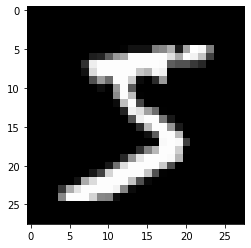

In [19]:
draw_num(train_ds[0][0])

In [21]:
train_loader = torch.utils.data.DataLoader(
    train_ds,
    sampler=RandomSampler(train_ds),
    batch_size=config.batch_size,
    pin_memory=False,
    drop_last=False,
    num_workers=config.num_workers,
)

val_render_loader = torch.utils.data.DataLoader(
    valid_ds,
    sampler=RandomSampler(valid_ds),
    batch_size=config.batch_size*2,
    pin_memory=False,
    drop_last=False,
    num_workers=config.num_workers,
)

In [23]:
class CancelTrainException(Exception): pass
class CancelEpochException(Exception): pass
class CancelBatchException(Exception): pass

#abstract class for new callback
class Callback():
    _order = 0
    def _set_learner(self,learn): self.learn = learn
    def begin_fit(self): pass
    def after_fit(self): pass
    def begin_epoch(self): pass
    def begin_validate(self): pass
    def after_epoch(self): pass
    def begin_batch(self): pass
    def after_batch(self): pass
    def after_loss(self): pass
    def begin_backward(self): pass
    def after_backward(self): pass
    def after_step(self): pass
    def after_cancel_train(self): pass   
    def after_cancel_epoch(self): pass
    def after_cancel_batch(self): pass

In [26]:
class NewLearner():
    def __init__(self, model, loss_func, dls, cbs=None):
        self.model,self.loss_func,self.dls = model,loss_func,dls
        self.in_train = False
        self.cbs = []
        self.cbs.append()
        if cbs:
            for cb in sorted(cbs,key = lambda x: x._order):
                self.cbs.append(cb)
        
    def one_batch(self,xb,yb):
        try: 
            self.xb, self.yb = xb, yb
            for cb in self.cbs: 
                cb.begin_batch()
            self.preds = self.model(self.xb)
            self.loss = self.loss_func(self.preds,self.yb)
            for cb in self.cbs: 
                cb.after_loss()
            
            if not self.in_train: return
            
            for cb in self.cbs: 
                cb.begin_backward()
            self.loss.backward()
            for cb in self.cbs: 
                cb.after_backward()
            self.opt.step()
            for cb in self.cbs: 
                cb.after_step()
            self.opt.zero_grad()
            
        except CancelBatchException: 
            for cb in self.cbs: 
                cb.after_cancel_batch()
        
        finally:
            for cb in self.cbs: 
                cb.after_batch()

    def all_batches(self):
        try:
            for xb,yb in self.dl:
                self.one_batch(xb,yb)
        except CancelEpochException: 
            for cb in self.cbs: 
                cb.after_cancel_epoch()


    def fit(self,epochs):
        self.epochs = epochs
        self.iters = len(self.dls[0])
        try:
            for cb in self.cbs: 
                cb._set_learner(self)
            for cb in self.cbs: 
                cb.begin_fit()
            for epoch in range(epochs):
                self.epoch = epoch
                self.dl = self.dls[0]
                for cb in self.cbs: 
                    cb.begin_epoch()
                self.all_batches()
        
                for cb in self.cbs: 
                    cb.begin_validate()
                self.dl = self.dls[1]
                with torch.no_grad(): 
                    self.all_batches()
                for cb in self.cbs: 
                    cb.after_epoch()
                
        except CancelTrainException: 
            for cb in self.cbs: 
                cb.after_cancel_train()
                
        finally:
            for cb in self.cbs: 
                cb.after_fit()
            self.cbs.clear()